Theme

# Setup

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import string

Data_SetCol=['user', 'text', 'followers', 'location', 'verified', 'sentiment']
Data_SetEnc = "utf-8"

In [2]:
south = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='SouthwestAir')
south['airline'] = 'SouthwestAir'
jetblue = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='JetBlue')
jetblue['airline'] = 'JetBlue'


df = pd.concat(
    [
        south,
        jetblue
    ]
)

df = df.loc[df.Sentimiento.isin([1,-1]), ['Texto', 'Sentimiento','airline']]
df.columns = [x.lower() for x in df.columns]
df = df.rename(columns={'sentimiento':'sentiment', 'texto':'text'})

print('length of data is ', len(df))



df.info()

df.dtypes

df.head(5)

length of data is  2712
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 1 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       2712 non-null   object 
 1   sentiment  2712 non-null   float64
 2   airline    2712 non-null   object 
dtypes: float64(1), object(2)
memory usage: 84.8+ KB


,text,sentiment,airline
1,@SouthwestAir I ❤️ SWA,1.0,SouthwestAir
3,@SouthwestAir has ripped me off by delaying my...,-1.0,SouthwestAir
5,@SouthwestAir I checked two bags and still had...,1.0,SouthwestAir
8,@SouthwestAir Just looked at flights to Seattl...,1.0,SouthwestAir
9,@Mike__Green @SouthwestAir And any last shred ...,-1.0,SouthwestAir


In [3]:
np.sum(df.isnull().any(axis=1))

0

In [4]:
print('Number of columns in the data is: ', len(df.columns))
print('Number of rows in the data is: ', len(df))

df['sentiment'].unique()
df['sentiment'].nunique()

Number of columns in the data is:  3
Number of rows in the data is:  2712


2

<AxesSubplot:xlabel='sentiment', ylabel='count'>

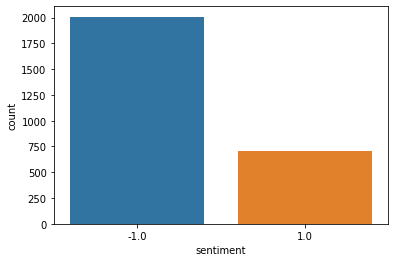

In [5]:
sns.countplot(x='sentiment', data=df)

In [6]:
data = df[['text','sentiment']]
data['sentiment'].unique()

pos_sent = data[data['sentiment'] == 1]
neg_sent = data[data['sentiment'] == 0]
neu_sent = data[data['sentiment'] == -1]

pos_sent = pos_sent.iloc[:int(2500)]
neg_sent = neg_sent.iloc[:int(2500)]
neu_sent = neu_sent.iloc[:int(2500)]

dataset = pd.concat([pos_sent, neg_sent, neu_sent])

dataset['text'] = dataset['text'].str.lower()
dataset['text'].tail()

stop_words_list = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

stop_words = set(stop_words_list)
def clean_stopwords(text): 
    return " ".join([word for word in str(text).split() if word not in stop_words_list])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))

eng_punc = string.punctuation
punc_list = eng_punc
def clean_punctuation(text): 
    translator = str.maketrans('','', punc_list)
    return text.translate(translator)
dataset['text'] = dataset['text'].apply(lambda x: clean_punctuation(x))

def clean_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: clean_repeating_char(x))

def clean_URLs(data):
    return re.sub(r'^https?:\/\/.*[\r\n]*',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: clean_URLs(x))

def clean_numb(data):
    return re.sub('[0-9]+', '',data)
dataset['text'] = dataset['text'].apply(lambda x: clean_numb(x))

token = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(token.tokenize)

sufixes = nltk.PorterStemmer()
def stemming_text(data):
    text = [sufixes.stem(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: stemming_text(x))

lemma = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lemma.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()


1     [w, w]
5        [w]
8        [w]
10       [w]
13       [w]
Name: text, dtype: object

# Model

              precision    recall  f1-score   support

        -1.0       0.95      0.98      0.97       101
         1.0       0.94      0.86      0.90        35

    accuracy                           0.95       136
   macro avg       0.94      0.92      0.93       136
weighted avg       0.95      0.95      0.95       136

0.9186704384724187


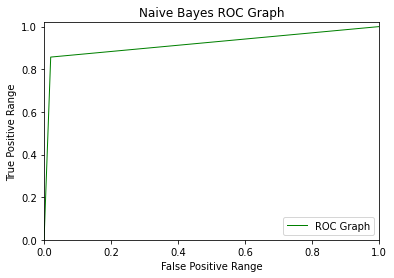

              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89       101
         1.0       1.00      0.26      0.41        35

    accuracy                           0.81       136
   macro avg       0.90      0.63      0.65       136
weighted avg       0.85      0.81      0.76       136

              precision    recall  f1-score   support

        -1.0       0.88      0.99      0.93       101
         1.0       0.95      0.60      0.74        35

    accuracy                           0.89       136
   macro avg       0.92      0.80      0.83       136
weighted avg       0.90      0.89      0.88       136

0.7950495049504951


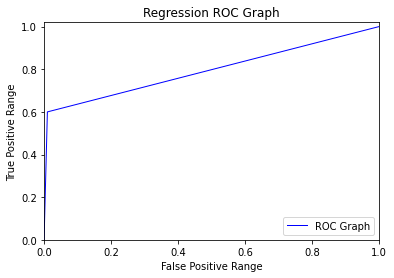

In [7]:

x = data.text
y = data.sentiment

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.05, random_state =26105111)

vector = TfidfVectorizer(ngram_range = (1,2), max_features = 10000 )
vector.fit(x_train)

x_train = vector.transform(x_train)
x_test = vector.transform(x_test)

def model_ev(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))

naive_bayes = BernoulliNB()
naive_bayes.fit(x_train, y_train)
model_ev(naive_bayes)
y_pred_1 = naive_bayes.predict(x_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_1)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color = 'green', lw = 1, label = 'ROC Graph' % roc_auc)
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Range')
plt.ylabel('True Positive Range')
plt.title('Naive Bayes ROC Graph')
plt.legend(loc = "lower right")
plt.show()

model=MultinomialNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cf = classification_report(y_test, y_pred)
print(cf)


logistic_regression = LogisticRegression(C = 2, max_iter = 500, n_jobs = -1)
logistic_regression.fit(x_train, y_train)
model_ev(logistic_regression)
y_pred_2 = logistic_regression.predict(x_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_2)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color = 'blue', lw = 1, label = 'ROC Graph' % roc_auc)
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Range')
plt.ylabel('True Positive Range')
plt.title('Regression ROC Graph')
plt.legend(loc = "lower right")
plt.show()